In [1]:
import mitsuba as mi
mi.set_variant('cuda_ad_rgb')
import matplotlib.pyplot as plt
import os

from calibration.helpers.io import *
from calibration.helpers.camera_model import *
from calibration.helpers.linear_alg import *
from mitsuba import ScalarTransform4f as T

import drjit as dr

from ipywidgets import interact

## Paths

In [2]:
folder_dataset = '../datasets/'
folder_params = 'data'
dataset_name = 'unanno36_sorted256_theta_5_70_8_phi_0_360_16'
path_dataset = os.path.join(folder_dataset, dataset_name)
path_params = os.path.join(folder_params, 'npp_' + dataset_name + '.npy')

## Functions

In [3]:
def to_world(dataset, arr_angles, params):
  """ Get to world matrix for a given set of angles """
  # Filtering can be optimized
  arr_mtx = []

  for angles_inp in arr_angles:
    for i, entry in enumerate(dataset):
      angles, wo_measured, vargeo, pg_cam_matrix, ch_ids, ch_corners = entry[0] # No image required
      theta_i, phi_i, theta_o, phi_o = angles

      if theta_o == angles_inp[0] and \
         phi_o == angles_inp[1] and \
         vargeo == angles_inp[2]:

        mtx = get_to_world(params, pg_cam_matrix)
        mtx[:3, 3] *= 0.001
        arr_mtx.append(mtx)

  return np.array(arr_mtx)

In [4]:
def tfm_plane(params):
  ij_to_sample = rot_scipy(params[:3])
  ij_to_sample[0:3, 3] = params[3:6] * 0.001
  return T(ij_to_sample) @ T.translate([.31/2, .18/2, 0])

# Reconstructing from Captures

### Reconstruction

In [5]:
dataset = read_dataset(path_dataset, 64, v=True)
params_cam = load_params(path_params, v=True)

Reading ../datasets/unanno36_sorted256_theta_5_70_8_phi_0_360_16: 100%|██████████| 64/64 [00:19<00:00,  3.35it/s]


Loaded parameters from data/npp_unanno36_sorted256_theta_5_70_8_phi_0_360_16.npy
********************



In [6]:
thetas_uniq, phis_uniq, vars_uniq = get_dataset_angles(dataset)
print("Available angles")
print(thetas_uniq, phis_uniq, vars_uniq)

Available angles
[ 5 14 23 32 42 51 60 70] [  0  22  45  67  90 112 135 157 180 202 225 247 270 292 315 337] [0 1]


In [7]:
# [[theta1, phi1, var1], [theta2, phi2, var2]]
arr_angles = np.array([
  [5, 0, 1],
  [51, 0, 0],
  [70, 337, 0],
  [70, 225, 1],
])

arr_to_worlds = to_world(dataset, arr_angles, params_cam)
mtx_plane = tfm_plane(params_cam)

In [17]:
def_sample_count = 128
def_res_x = 6576 // 2
def_res_y = 4384 // 2
path_tex_targ = 'scenes/textures/charuco.png'
path_tex_init = 'scenes/textures/init.png'

def make_batch_cameras(yfov, resx, resy, arr_to_worlds):
  dict_cameras = {}

  for i, mtx in enumerate(arr_to_worlds):
    dict_cameras[f"camera_{i}"] = {
      'type': 'perspective',
      'fov_axis': 'x',
      'near_clip': 0.001,
      'far_clip': 1000.0,
      'fov': yfov * 1.5,
      'to_world': T(mtx),
    }
  
  dict_sensors = {
    'type': 'batch',
    # Sampler
    'sampler': {
      'type': 'independent',
      'sample_count': def_sample_count,
    },
    # Film
    'film': {
      'type': 'hdrfilm',
      # Change the film size to match the batch size
      'width': arr_to_worlds.shape[0] * resx,
      'height': resy,
      'rfilter': {
        'type': 'tent',
      }
    }
  }

  dict_sensors.update(dict_cameras)

  return dict_sensors

def make_board_scene(path_tex, resx, resy, mtx_plane, dict_to_worlds):
  dict_sensors = make_batch_cameras(params_cam[6], resx, resy, arr_to_worlds)
  sensors = mi.load_dict(dict_sensors)

  scene =  mi.load_dict({
    'type': 'scene',
    # Integrator
    'integrator': {
      'type': 'prb',
      'max_depth': 8,
    },

    # Sensor
    'sensors': sensors, 

    # BSDFS
    'charuco': {
        'type': 'twosided',
        'material': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'bitmap',
                'filename': path_tex,
                'filter_type': 'bilinear',
            }
        },
    },

    # Light
    'light': {
      'type': 'constant',
      'radiance': {
        'type': 'rgb',
        'value': 1.0,
      }
    },

    # Shapes
    'tex_plane': {
      'type': 'obj',
      'filename': 'scenes/meshes/tex_plane.obj',
      'to_world': T(mtx_plane) @ T.rotate(axis=[0,1,0], angle=-90),
      'bsdf': {
        'type': 'ref',
        'id': 'charuco',
      },
    }
  })


  return scene

In [18]:
scene_opt = make_board_scene(path_tex_init, def_res_x, def_res_y, mtx_plane, arr_to_worlds)

In [11]:
## Read Images
ref_img_0 = mi.TensorXf(mi.Bitmap('./captures/0_0_5_0_1.png').convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.Float32).resample([def_res_x, def_res_y]))
ref_img_1 = mi.TensorXf(mi.Bitmap('./captures/0_0_51_0_0.png').convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.Float32).resample([def_res_x, def_res_y]))
ref_img_2 = mi.TensorXf(mi.Bitmap('./captures/0_0_70_337_0.png').convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.Float32).resample([def_res_x, def_res_y]))
ref_img_3 = mi.TensorXf(mi.Bitmap('./captures/0_0_70_225_1.png').convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.Float32).resample([def_res_x, def_res_y]))


ref_img = mi.TensorXf(np.hstack((ref_img_0, ref_img_1, ref_img_2, ref_img_3)))

In [19]:
params = mi.traverse(scene_opt)
param_key = 'charuco.brdf_0.reflectance.data'
opt = mi.ad.Adam(lr=0.1)
opt[param_key] = params[param_key]
params.update(opt);

In [20]:
init_img = mi.render(scene_opt, spp=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


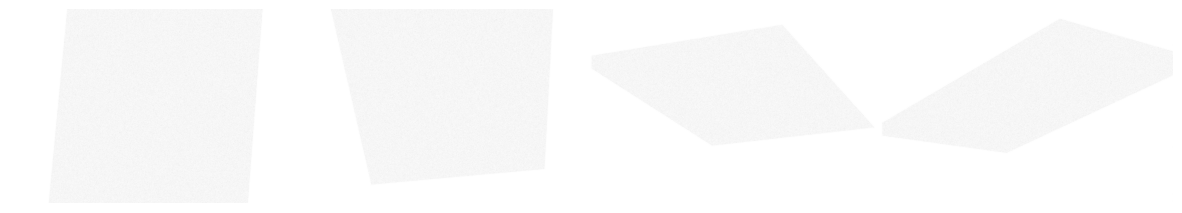

In [21]:
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(init_img);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


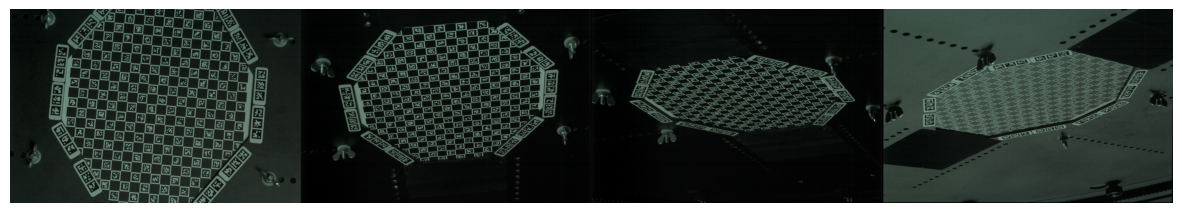

In [22]:
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(ref_img);

In [23]:
iteration_count = 100
errors = []
for it in range(iteration_count):
    # Perform a (noisy) differentiable rendering of the scene
    image = mi.render(scene_opt, params, seed=it, spp=1)
    
    # Evaluate the objective function from the current rendered image
    loss = dr.mean(dr.sqr(image - ref_img))

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    opt[param_key] = dr.clamp(opt[param_key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)
    
    # Display loss
    print(f"Iteration {it:02d}: parameter error = {loss[0]:6f}", end='\r')
    errors.append(loss)
print('\nOptimization complete.')

Iteration 99: parameter error = 0.419595
Optimization complete.


In [24]:
params_ref_bm = mi.util.convert_to_bitmap(params[param_key]).convert(mi.Bitmap.PixelFormat.RGB,
                                                              mi.Struct.Type.UInt8, False)

In [25]:
mi.util.write_bitmap(f'recon_tex.png', params_ref_bm, write_async=True)

In [26]:
image_final = mi.render(scene_opt, spp=16)
mi.util.write_bitmap(f'final_image.png', image_final, write_async=True)

In [27]:
mi.util.write_bitmap('ref_image.png', ref_img, write_async=True)

: 

## Scratch

### cbox python dict

In [19]:
def_sample_count = 128
def_res = 512
path_tex = 'scenes/textures/charuco.png'

scene = mi.load_dict({
    'type': 'scene',

    # Integrator
    'integrator': {
        'type': 'path',
        'max_depth': 8
    },
    # Sensor
    'sensor': {
        'type': 'perspective',
        'fov_axis': 'x',
        'near_clip': 0.001,
        'far_clip': 100.0,
        'focus_distance': 1000,
        'fov': 39.3077,
        'to_world': T.look_at(
            origin = [0, 0, 4],
            target = [0, 0, 0],
            up = [0, 1, 0]
        ),
        # Sampler
        'sampler': {
            'type': 'independent',
            'sample_count': def_sample_count,
        },
        # Film
        'film': {
            'type': 'hdrfilm',
            'width': def_res,
            'height': def_res,
            'rfilter': {
                'type': 'tent',
            }
        }
    },
    # BSDFs
    'gray': {
        'type': 'diffuse',
        'reflectance': {
            'type': 'rgb',
            'value': [0.85, 0.85, 0.85],
        }
    },
    'white': {
        'type': 'diffuse',
        'reflectance': {
            'type': 'rgb',
            'value': [0.885809, 0.698859, 0.666422],
        }
    },
    'green': {
        'type': 'diffuse',
        'reflectance': {
            'type': 'rgb',
            'value': [0.105421, 0.37798, 0.076425],
        }
    },
    'red': {
        'type': 'diffuse',
        'reflectance': {
            'type': 'rgb',
            'value': [0.570068, 0.0430135, 0.0443706],
        },
    },
    'charuco': {
        'type': 'twosided',
        'material': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'bitmap',
                'filename': path_tex,
                'filter_type': 'bilinear'
            }
        }
    },
    # Light
    'light': {
        'type': 'obj',
        'filename': 'scenes/meshes/cbox_luminaire.obj',
        'to_world': T.translate([0.0, -0.01, 0.3]),
        'bsdf': {
            'type': 'ref',
            'id': 'white',
        },
        'ceiling': {
            'type': 'area',
            'radiance': {
                'type': 'rgb',
                'value': [10, 10, 10],
            }
        }
    },
    # Shapes
    'floor': {
        'type': 'obj',
        'filename': 'scenes/meshes/cbox_floor.obj',
        'bsdf': {
            'type': 'ref',
            'id': 'white',
        },
    },
    'ceiling': {
        'type': 'obj',
        'filename': 'scenes/meshes/cbox_ceiling.obj',
        'bsdf': {
            'type': 'ref',
            'id': 'white',
        },
    },
    'back': {
        'type': 'obj',
        'filename': 'scenes/meshes/cbox_back.obj',
        'bsdf': {
            'type': 'ref',
            'id': 'white',
        },
    },
    'greenwall': {
        'type': 'obj',
        'filename': 'scenes/meshes/cbox_greenwall.obj',
        'bsdf': {
            'type': 'ref',
            'id': 'green',
        },
    },
    'redwall': {
        'type': 'obj',
        'filename': 'scenes/meshes/cbox_redwall.obj',
        'bsdf': {
            'type': 'ref',
            'id': 'red',
        },  
    },
    'tex_plane': {
        'type': 'obj',
        'filename': 'scenes/meshes/tex_plane.obj',
        'to_world': T.rotate(axis=[0,1,0], angle=-90),
        'bsdf': {
            'type': 'ref',
            'id': 'charuco',
        },
    }

})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


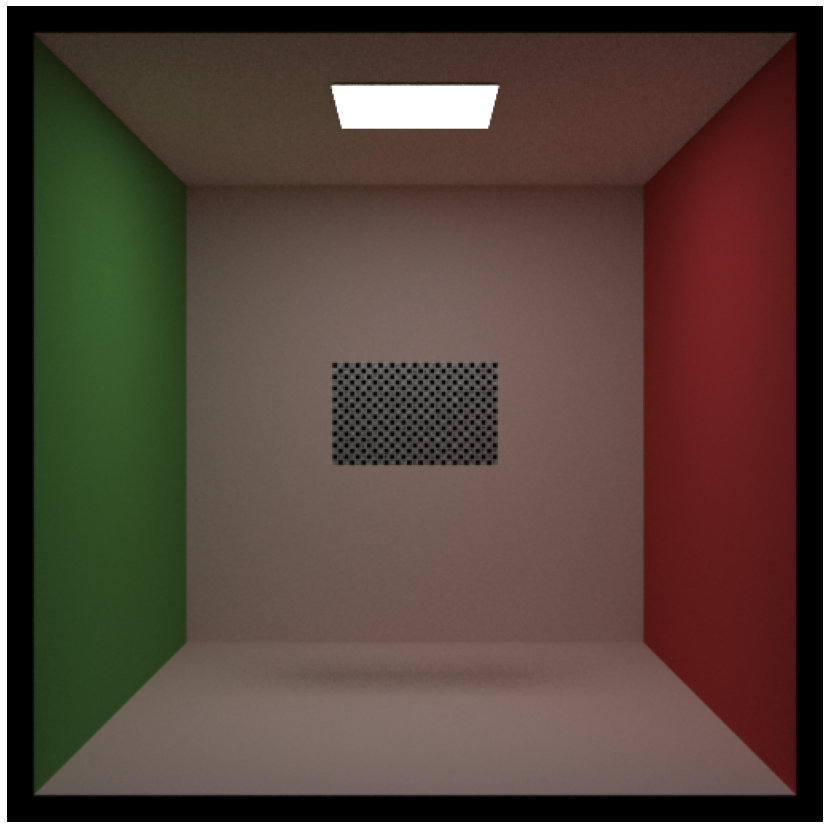

In [42]:
# scene = mi.load_file("scenes/cbox.xml")
original_image = mi.render(scene, spp=128)

plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(original_image ** (1.0 / 2.2));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


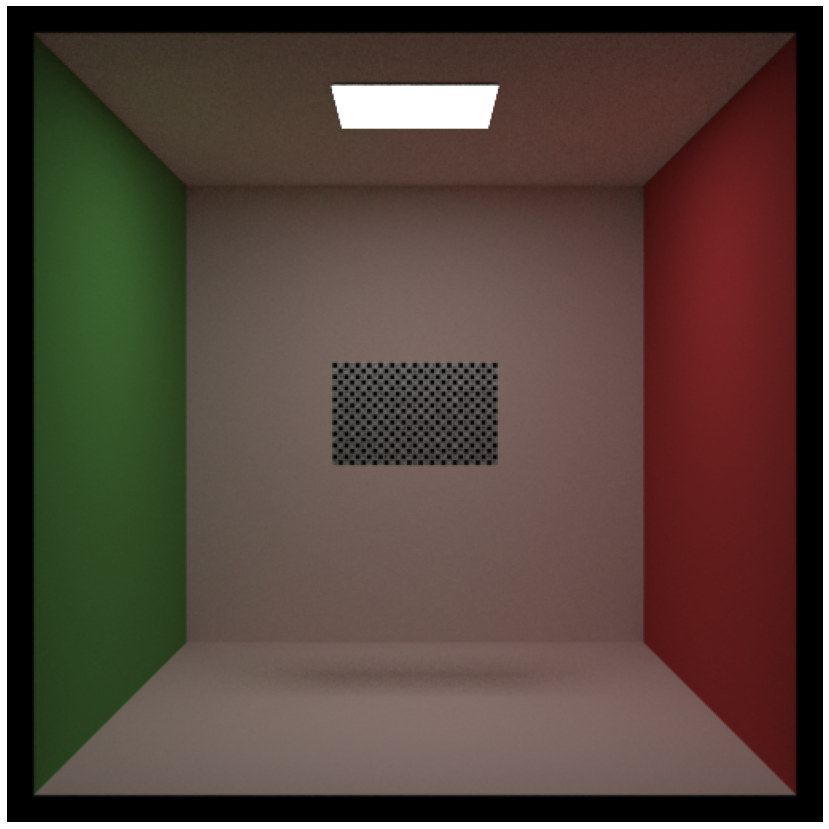

In [43]:
scene = mi.load_file("scenes/cbox.xml")
original_image = mi.render(scene, spp=128)

plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(original_image ** (1.0 / 2.2));

In [19]:
a = np.array([[1, 2], [3, 4], [1, 3], [5, 6]])
idxs_theta = np.where(a[:,0]==1)[0]
idxs_phi = np.where(a[idxs_theta]==2)[0]
len(idxs_theta) and len(idxs_phi)

1

In [ ]:
mi.Transform4f.perspective()